In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123456)
%matplotlib inline

In [2]:
csv = pd.read_csv('listing-of-illegal-health-products-found-in-singapore.csv')

csv.head()

,product_name,dosage_form,dosage_form_colour,dosage_form_shape,dosage_form_marking,adulterant_type,manufacturer_name,manufacturer_country
0,18 Spring Gel (十八春催情缩阴精华素),Gel,Transparent,na,na,Sildenafil,na,na
1,4X Lebih Dahsyat Obat Kuat & Tahan Lama Urat M...,Capsule,Red,Oblong,URAT MADU,Sildenafil,PJ. AIR MADU Malang,Indonesia
2,Africa Black Ant 2500mg Capsule (非洲黑蚁王),Capsule,White,Oblong,金聖力,Sibutramine; Sildenafil; Tadalafil; Imidazosag...,na,na
3,African Superman (非洲超人),Tablet,Black,Oblong,AVLS,Sildenafil,African Duoronzi Medicine Nations Group Neimen...,Tibet
4,Aidi Brand Wodibo Capsule (艾迪牌五便宝胶囊),Capsule,Blue,Oblong,na,Sildenafil; Tadalafil,Shang Qiu Shi Ai Di Bao Jian Pin You Xian Gong...,na


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

adulterant_column = csv['adulterant_type']

vectorizer = CountVectorizer(tokenizer=lambda str: str.split('; ')).fit(adulterant_column)

word_count = vectorizer.transform(adulterant_column).toarray()
feature_list = vectorizer.get_feature_names()

overall_term_frequencies = sorted(zip(feature_list, word_count.sum(axis=0)), key=lambda item: item[1], reverse=True)

(-0.5, 399.5, 399.5, -0.5)

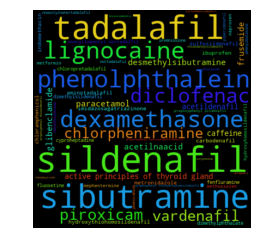

In [4]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=400, height=400,
                      max_font_size=100, prefer_horizontal=0.7).generate_from_frequencies(overall_term_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [5]:
print('Most common adulterants')
overall_term_frequencies[:5]

Most common adulterants


[('sildenafil', 156),
 ('sibutramine', 57),
 ('tadalafil', 30),
 ('phenolphthalein', 22),
 ('lignocaine', 21)]

In [6]:
from sklearn.decomposition import PCA

pca = PCA().fit(word_count)

reduced = pca.transform(word_count)

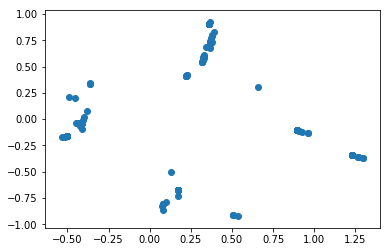

In [7]:
x = reduced[:, 0]
y = reduced[:, 1]

plt.scatter(x, y, marker="o")

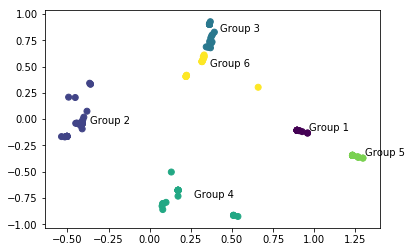

In [8]:
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters).fit(reduced[:, :2])

plt.scatter(x, y, c=kmeans.labels_, marker="o")

for idx, center in enumerate(kmeans.cluster_centers_):
    plt.annotate('Group %d' % (idx + 1), xy=center, xytext=(10, 0), textcoords='offset points')

plt.show()

In [9]:
csv['assigned_label'] = kmeans.labels_
csv['adulterant_type'] = adulterant_column.map(vectorizer.build_tokenizer())

grouped = csv.groupby('assigned_label')

print('Sanity check')
print()

for label, group in grouped:
    print('Group %d' % (label + 1))
    print(group['adulterant_type'][:5])
    print()

Sanity check

Group 1
7     [Sibutramine]
11    [Sibutramine]
27    [Sibutramine]
39    [Sibutramine]
89    [Sibutramine]
Name: adulterant_type, dtype: object

Group 2
0                           [Sildenafil]
1                           [Sildenafil]
3                           [Sildenafil]
4                [Sildenafil, Tadalafil]
6    [Sildenafil, Tadalafil, Vardenafil]
Name: adulterant_type, dtype: object

Group 3
5                                          [Lignocaine]
15             [Chlorpheniramine, Frusemide, Piroxicam]
33    [Chlorpheniramine, Frusemide, Piroxicam, Mephe...
36                                         [Lignocaine]
40                                         [Lignocaine]
Name: adulterant_type, dtype: object

Group 4
2     [Sibutramine, Sildenafil, Tadalafil, Imidazosa...
10                            [Sibutramine, Sildenafil]
34                            [Sibutramine, Sildenafil]
61    [Sibutramine, Sildenafil, Glibenclamide, Tadal...
64     [Sibutramine, Sildenafil

In [10]:
print('First principal component')
sorted(zip(feature_list, pca.components_[0]), key=lambda x: abs(x[1]), reverse=True)[:10]

First principal component


[('sildenafil', -0.72354110156710616),
 ('sibutramine', 0.58273626958419567),
 ('phenolphthalein', 0.33688346749609221),
 ('tadalafil', -0.092712698312908695),
 ('desmethylsibutramine', 0.063566733122196073),
 ('lignocaine', 0.050111869574408718),
 ('dexamethasone', 0.036751486569713894),
 ('caffeine', 0.03574525807984924),
 ('vardenafil', -0.033333478110014463),
 ('active principles of thyroid gland', 0.030861928283970608)]

In [11]:
print('2nd principal component')
sorted(zip(feature_list, pca.components_[1]), key=lambda x: abs(x[1]), reverse=True)[:10]

2nd principal component


[('sibutramine', -0.64006251845460194),
 ('sildenafil', -0.57015696852503361),
 ('lignocaine', 0.36971047694559517),
 ('phenolphthalein', -0.23798734758176038),
 ('dexamethasone', 0.13242782803423489),
 ('tadalafil', -0.12735963879521478),
 ('piroxicam', 0.098349409208464106),
 ('chlorpheniramine', 0.079513090500531014),
 ('frusemide', 0.061042791051571954),
 ('glibenclamide', -0.055841699918238882)]